# Data Statistics

In [1]:
import os
import pandas as pd
import sys
sys.path.append('../')

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
# Load the processed dataset
df = pd.read_json("../data/single_word_with_replacement.jsonl", lines=True)

In [4]:
df_full = pd.read_json("../raw-data/acl_anthology/data_acl_all.jsonl", lines=True).drop_duplicates(subset=['Acronym', 'Description', 'Abstract']).reset_index(drop=True)

## Plot the Distribution of Text Length

In [5]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [ ]:
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained("t5-base")

In [7]:
df["acronym_tok_len"] = df["Acronym"].apply(lambda x: len(tokenizer.tokenize(x)))  # tok level
df["acronym_len"] = df["Acronym"].apply(lambda x: len(x))   # char level
df["description_tok_len"] = df["Description"].apply(lambda x: len(tokenizer.tokenize(x)))   # tok level
df["abstract_tok_len"] = df["Abstract"].apply(lambda x: len(tokenizer.tokenize(x)))   # tok level

Token indices sequence length is longer than the specified maximum sequence length for this model (567 > 512). Running this sequence through the model will result in indexing errors


In [8]:
# Print the statistics
print("Acronym token length: ", df["acronym_tok_len"].mean())
print("Acronym character length: ", df["acronym_len"].mean())
print("Description token length: ", df["description_tok_len"].mean())
print("Abstract token length: ", df["abstract_tok_len"].mean())

Acronym token length:  3.521418908762964
Acronym character length:  6.955659101157373
Description token length:  14.994889523523222
Abstract token length:  220.3203066285886


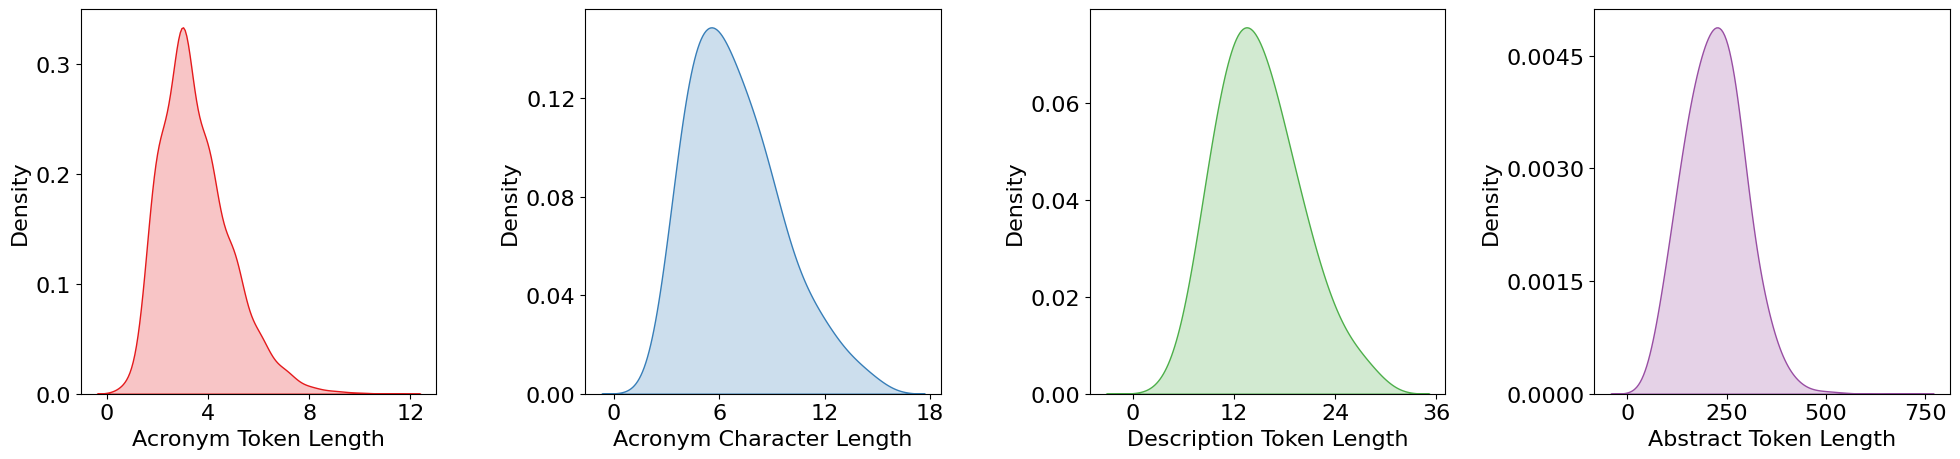

In [22]:
palette = sns.color_palette("Set1", 4)
fig, ax = plt.subplots(1, 4, figsize=(20, 5))

# Make the font size larger
plt.rcParams.update({'font.size': 20})

# Set exactly 4 ticks for each x-axis
for i in range(4):
    # ax[i].xaxis.set_major_locator(plt.MaxNLocator(4))
    ax[i].yaxis.set_major_locator(plt.MaxNLocator(4))
    
ax[0].set_xticks([0, 4, 8, 12])
ax[1].set_xticks([0, 6, 12, 18])
ax[2].set_xticks([0, 12, 24, 36])
ax[3].set_xticks([0, 250, 500, 750])

sns.kdeplot(df["acronym_tok_len"], fill=True, bw_adjust=2, ax=ax[0], color=palette[0])
ax[0].set_xlabel("Acronym Token Length")
sns.kdeplot(df["acronym_len"], fill=True, bw_adjust=2, ax=ax[1], color=palette[1])
ax[1].set_xlabel("Acronym Character Length")
sns.kdeplot(df["description_tok_len"], fill=True, bw_adjust=2, ax=ax[2], color=palette[2])
ax[2].set_xlabel("Description Token Length")
sns.kdeplot(df["abstract_tok_len"], fill=True, bw_adjust=2, ax=ax[3], color=palette[3])
ax[3].set_xlabel("Abstract Token Length")

plt.tight_layout()
plt.savefig("../image/length.pdf", bbox_inches='tight')

## Plot the Distribution of Papers in the Final Dataset

In [10]:
df["Year"] = df["Year"].astype(int)
df_full["Year"] = df_full["Year"].astype(int)

In [11]:
# df["Year_group"] = pd.cut(df["Year"], bins=[1951, 1963, 1973, 1983, 1993, 1998, 2003, 2008, 2013, 2018, 2023], labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# df_full["Year_group"] = pd.cut(df_full["Year"], bins=[1951, 1963, 1973, 1983, 1993, 1998, 2003, 2008, 2013, 2018, 2023], labels=[1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
df["Year_group"] = pd.cut(df["Year"], bins=[1951, 1963, 1973, 1983, 1993, 2003, 2013, 2023], labels=[1, 2, 3, 4, 5, 6, 7])
df_full["Year_group"] = pd.cut(df_full["Year"], bins=[1951, 1963, 1973, 1983, 1993, 2003, 2013, 2023], labels=[1, 2, 3, 4, 5, 6, 7])

In [12]:
df_year = df.groupby("Year_group").count()
df_year_full = df_full.groupby("Year_group").count()

In [16]:
df_year_distribution = pd.merge(df_year, df_year_full, on="Year_group")
df_year_distribution = df_year_distribution[["Venue_x", "Venue_y"]]
df_year_distribution = df_year_distribution.rename(columns={"Venue_x": "Processed_Count", "Venue_y": "Raw_Count"})

In [17]:
df_year_distribution["Proportion"] = df_year_distribution["Processed_Count"] / df_year_distribution["Raw_Count"]
df_year_distribution

,Processed_Count,Raw_Count,Proportion
Year_group,,,
1,0,2,0.000000
2,0,105,0.000000
3,1,193,0.005181
4,19,847,0.022432
5,135,1543,0.087492
6,999,4814,0.207520
7,5499,17700,0.310678


In [18]:
df_year_distribution = df_year_distribution.reset_index()
df_year_distribution

,Year_group,Processed_Count,Raw_Count,Proportion
0,1,0,2,0.000000
1,2,0,105,0.000000
2,3,1,193,0.005181
3,4,19,847,0.022432
4,5,135,1543,0.087492
5,6,999,4814,0.207520
6,7,5499,17700,0.310678


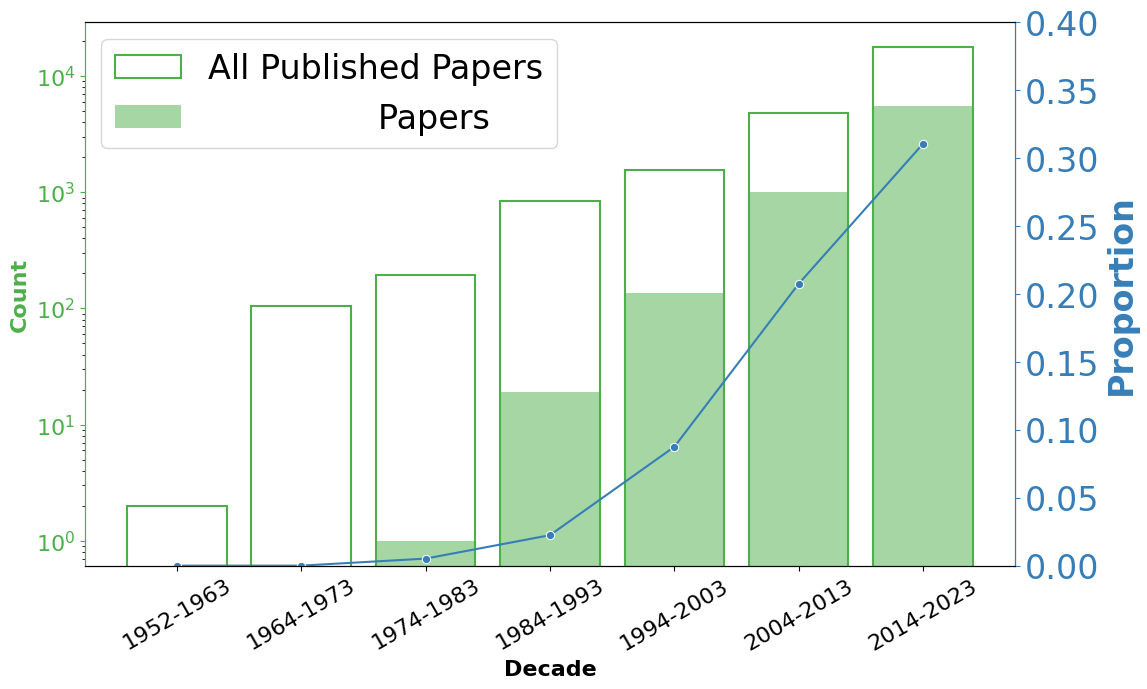

In [19]:
# Draw the bar plot of two counts into one plot. The processed count is in the raw count

fig, ax = plt.subplots(figsize=(12, 7.416))

# Make the font size larger
plt.rcParams.update({'font.size': 24})

ax.bar(df_year_distribution["Year_group"], df_year_distribution["Raw_Count"], color=palette[2], label="All Published Papers", fill=False, edgecolor=palette[2], linewidth=1.5, alpha=1)
ax.bar(df_year_distribution["Year_group"], df_year_distribution["Processed_Count"], color=palette[2], label="                Papers", alpha=0.5)

# y-axis
ax.spines['left'].set_color(palette[2])
ax.set_ylabel("Count", color=palette[2], fontweight=800)
ax.set_yscale("log")
ax.tick_params(axis='y', colors=palette[2])

# x-axis
# ax.set_xticks([1, 2, 3, 4, 5, 6, 7, 8, 9, 10])
# ax.set_xticklabels(["1952-1963", "1964-1973", "1974-1983", "1984-1993", "1994-1998", "1999-2003", "2004-2008", "2009-2013", "2014-2018", "2019-2023"])
ax.set_xticks([1, 2, 3, 4, 5, 6, 7])
ax.set_xticklabels(["1952-1963", "1964-1973", "1974-1983", "1984-1993", "1994-2003", "2004-2013", "2014-2023"], rotation=30)
ax.set_xlabel("Decade", fontweight=800)

ax.legend()

# Plot another line plot for the proportion
ax2 = ax.twinx()
sns.lineplot(x=df_year_distribution["Year_group"], y=df_year_distribution["Proportion"], ax=ax2, color=palette[1], marker="o", alpha=1)
ax2.spines['right'].set_color(palette[1])
ax2.spines['left'].set_color(palette[2])
ax2.set_ylabel("Proportion", color=palette[1], fontweight=800)
ax2.tick_params(axis='y', colors=palette[1])
ax2.set_ylim(0, 0.4)

plt.tight_layout()

# set margin when saving
plt.savefig("../image/proportion.pdf", bbox_inches='tight')

## Draw the Distribution of WL, WO, and LR

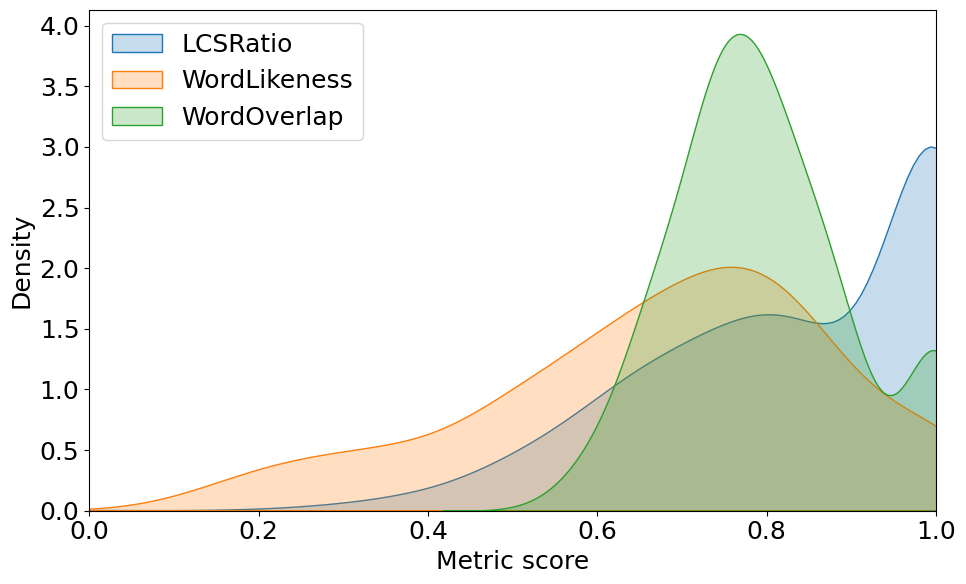

In [20]:
# Make the font size larger
plt.rcParams.update({'font.size': 18})

# Set figure size
plt.figure(figsize=(10, 6.18))

sns.kdeplot(df.lcsratio, fill=True, bw_adjust=2)
sns.kdeplot(df.wordlikeness, fill=True, bw_adjust=2)
sns.kdeplot(df.wordcoverage, fill=True, bw_adjust=2)
plt.xlim(0, 1)
plt.legend(["LCSRatio", "WordLikeness", "WordOverlap"], loc="upper left")
plt.xlabel("Metric score")
plt.tight_layout()
plt.savefig("../image/metrics.pdf", bbox_inches='tight')

## Draw the 3D Scatter Plot of WL, WO, and LR

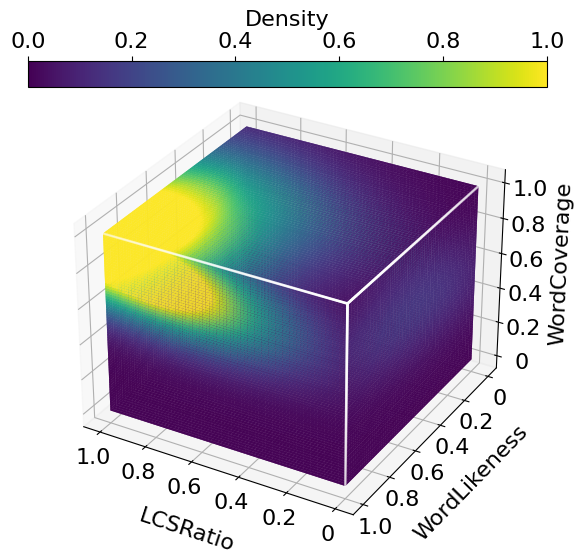

In [21]:

from mpl_toolkits.mplot3d import Axes3D
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from scipy.stats import gaussian_kde
from matplotlib import cm

x, y, z = df['lcsratio'], df['wordlikeness'], df['wordcoverage']

# Make the font size larger
plt.rcParams.update({'font.size': 16})

# Compute the Gaussian KDE
xyz = np.vstack([x, y, z])
# Calculate density on a grid
kde = gaussian_kde(xyz, bw_method=2)
# Define the grid
grid_size = 70
grid_x, grid_y, grid_z = np.mgrid[0:1:complex(grid_size), 0:1:complex(grid_size), 0:1:complex(grid_size)]
grid = np.vstack([grid_x.ravel(), grid_y.ravel(), grid_z.ravel()])
density = kde(grid).reshape((grid_size,)*3)

# Define the threshold to create a filled effect inside the cube
threshold = 0

# Create a mask for voxels above the threshold
mask = density > threshold

# Map the density to colors
colors = cm.viridis(density)

# Plot
fig = plt.figure(figsize=(10, 7))
ax = fig.add_subplot(111, projection='3d')

# Add white lines to the cubic
s = 1
ls = 200
xline = np.linspace(0, 0, ls)
yline = np.linspace(grid_size, grid_size, ls)
zline = np.linspace(0, grid_size+0.01, ls)
ax.scatter(xline, yline, zline, color='white', s=s)
xline = np.linspace(0, 0, ls)
yline = np.linspace(0, grid_size+0.01, ls)
zline = np.linspace(grid_size, grid_size, ls)
ax.scatter(xline, yline, zline, color='white', s=s)
xline = np.linspace(-0.01, grid_size, ls)
yline = np.linspace(grid_size, grid_size, ls)
zline = np.linspace(grid_size, grid_size, ls)
ax.scatter(xline, yline, zline, color='white', s=s)

# Plot voxels
ax.voxels(mask, facecolors=colors, edgecolor=None, alpha=0.9, linewidth=0, shade=False)

# Set labels
ax.set_xlabel('LCSRatio', labelpad=10)
ax.set_xticks([i*(grid_size//5) for i in range(6)])
ax.set_xticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_ylabel('WordLikeness', labelpad=8)
ax.set_yticks([i*(grid_size//5) for i in range(6)])
ax.set_yticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.set_zlabel('WordCoverage', labelpad=6)
ax.set_zticks([i*(grid_size//5) for i in range(6)])
ax.set_zticklabels([0, 0.2, 0.4, 0.6, 0.8, 1.0])
ax.tick_params(axis='x', which='major', pad=0)
ax.tick_params(axis='y', which='major', pad=0)
ax.tick_params(axis='z', which='major', pad=3)

# Set the view angle to see (1, 1, 1) in the front
ax.view_init(30, 120)

# Adding a color bar, set height, move to top
cbar = plt.colorbar(cm.ScalarMappable(cmap=cm.viridis), ax=ax, pad=-0.04, shrink=0.67, aspect=20, location='top')
cbar.set_label('Density')
plt.savefig("../image/cubic.pdf", bbox_inches='tight')

## Plot the Radar Chart of Model Performance on Different Metrics

In [6]:
import matplotlib.lines
from matplotlib.transforms import Bbox, TransformedBbox
from matplotlib.legend_handler import HandlerBase
from matplotlib.image import BboxImage

class HandlerLineImage(HandlerBase):

    def __init__(self, path, space=15, offset = 10 ):
        self.space=space
        self.offset=offset
        self.image_data = plt.imread(path)        
        super(HandlerLineImage, self).__init__()

    def create_artists(self, legend, orig_handle,
                       xdescent, ydescent, width, height, fontsize, trans):

        l = matplotlib.lines.Line2D([xdescent+self.offset,xdescent+(width-self.space)/3.+self.offset],
                                     [ydescent+height/2., ydescent+height/2.])
        l.update_from(orig_handle)
        l.set_clip_on(False)
        l.set_transform(trans)

        bb = Bbox.from_bounds(xdescent +(width+self.space)/3.+self.offset,
                              ydescent,
                              height*self.image_data.shape[1]/self.image_data.shape[0],
                              height)

        tbb = TransformedBbox(bb, trans)
        image = BboxImage(tbb)
        image.set_data(self.image_data)

        self.update_prop(image, orig_handle, legend)
        return [l,image]

In [7]:
from math import pi

categories = ['Sum-D', 'Neology', 'Algorithm', 'Sum-A']
img_path_list = ["../image/da_tok_one.png", "../image/ad_tok_one.png", "../image/da_chr_one.png", "../image/ad_tok_pip.png"]

# Function to create radar plots for each column in a DataFrame
def create_radar_plots(df, description, ax):
    # Number of variables (categories)
    N = len(categories)

    # Compute angle each bar is centered on:
    angles = [n / float(N) * 2 * pi for n in range(N)]
    angles += angles[:1]

    # Draw one axe per variable + add labels
    ax.set_theta_offset(pi / 2)
    ax.set_theta_direction(-1)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)

    lines = []
    # Plot each column
    for column in df.columns:
        values = df[column].tolist()
        values += values[:1]  # Complete the loop
        if column == "da_tok_one" or column == "SFT":
            if description == "Comparison of Paradigms":
                line = ax.plot(angles, values, linewidth=3, linestyle='solid', label=column)
            else:
                line = ax.plot(angles, values, linewidth=3, linestyle='solid', label=" ")
            lines.append(line)
            ax.fill(angles, values, alpha=0.2)
        else:
            if description == "Comparison of Paradigms":
                line = ax.plot(angles, values, linewidth=2, linestyle='solid', label=column)
            else:  
                line = ax.plot(angles, values, linewidth=2, linestyle='solid', label=" ")
            lines.append(line)
            ax.fill(angles, values, alpha=0.1)  
                
    if description == "Supervised Fine-Tuning":
        ax.set_ylim(-9, 9)
        # set tick numbers
        ax.set_yticks([-9, -6, -3, 0, 3, 6, 9])
        ax.set_yticklabels(["-9%", "-6%", "-3%", "0%", "3%", "6%", "9%"])
    if description == "In-Context Learning":
        ax.set_ylim(-21, 21)
        # set tick numbers
        ax.set_yticks([-44, -33, -22, -11, 0, 11, 22])
        ax.set_yticklabels(["-44%", "-33%", "-22%", "-11%", "0%", "11%", "22%"])
    if description == "Reinforcement Learning":
        ax.set_ylim(-6, 6)
        # set tick numbers
        ax.set_yticks([-6, -4, -2, 0, 2, 4, 6])
        ax.set_yticklabels(["-6%", "-4%", "-2%", "0%", "2%", "4%", "6%"])
    if description == "Comparison of Paradigms":
        ax.set_ylim(-20, 4)
        ax.set_yticks([-20, -16, -12, -8, -4, 0, 4])
        ax.set_yticklabels(["-20%", "-16%", "-12%", "-8%", "-4%", "0%", "4%"])
    
    # Set title
    ax.set_title(description, size=18, color='royalblue', y=1.1, fontweight=800)
    
    if description == "Comparison of Paradigms":
        # Add legend and set position
        ax.legend(bbox_to_anchor=(1.3, 1.1))
    elif description == "In-Context Learning":
        # Add legend and replace the label with an image
        ax.legend(bbox_to_anchor=(1.5, 1.1), handler_map={line[0]: HandlerLineImage(img_path_list[i]) for i, line in enumerate(lines)}, handlelength=8, handletextpad=-1, borderpad=0.3)

In [8]:
results_1 = {
    "Supervised Fine-Tuning": pd.DataFrame({
        "da_tok_one": [ 0.000,  0.000,  0.000,  0.000],
        "ad_tok_one": [-1.997, -0.909,  1.958,  1.697],
        "da_chr_one": [-1.174, -1.068,  5.533,  4.281],
        "da_tok_pip": [-3.709,  3.181,  1.070, -7.999]
    }),
    "In-Context Learning": pd.DataFrame({
        "da_tok_one": [  0.000,  0.000,  0.000,  0.000],
        "ad_tok_one": [-14.755,  7.963, 15.689, 16.645],
        "da_chr_one": [  6.212,  4.446, 19.239,-38.750],
        "da_tok_pip": [ -2.557,  2.359, -5.742,-20.649]
    }),
    "Reinforcement Learning": pd.DataFrame({
        "da_tok_one": [ 0.000,  0.000,  0.000,  0.000],
        "ad_tok_one": [-3.664, -1.492, -0.313, -0.811],
        "da_chr_one": [-2.538, -1.699,  4.769,  3.004],
    })
}
results_2 = {
    "Comparison of Paradigms": pd.DataFrame({
        "SFT": [ 0.000,  0.000,  0.000,  0.000],
        "RL" : [-0.156,  1.049,  1.685,  1.085],
        "ICL":[-18.591, -5.674, -9.586,-12.719],
    })
}

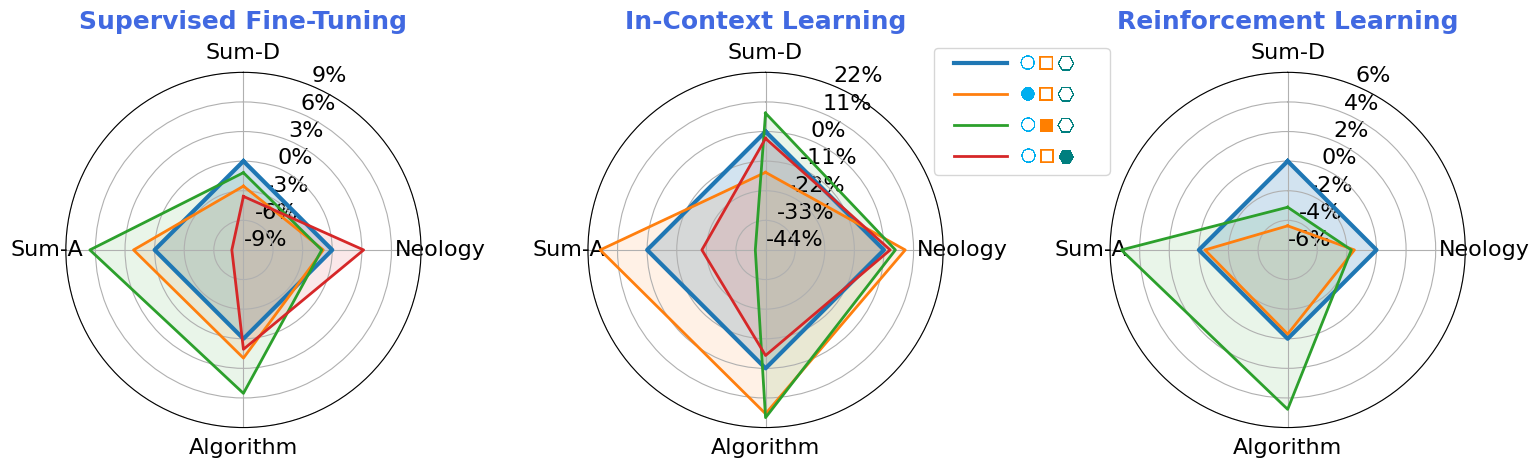

In [9]:
# Make the font size larger
plt.rcParams.update({'font.size': 16})

# Create a figure
fig, axs = plt.subplots(1, 3, figsize=(15, 5), subplot_kw=dict(polar=True))
plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1.8, 
                    top=0.9, 
                    wspace=0.8, 
                    hspace=0.9)

# Creating separate radar plots for each DataFrame entry
for i, (key, df) in enumerate(results_1.items()):
    # No adjustment needed for 'cp' entry, as it's already in the correct format
    create_radar_plots(df, key, axs[i])

# Show plot
plt.tight_layout()
plt.savefig("../image/radar_1.pdf", bbox_inches='tight')

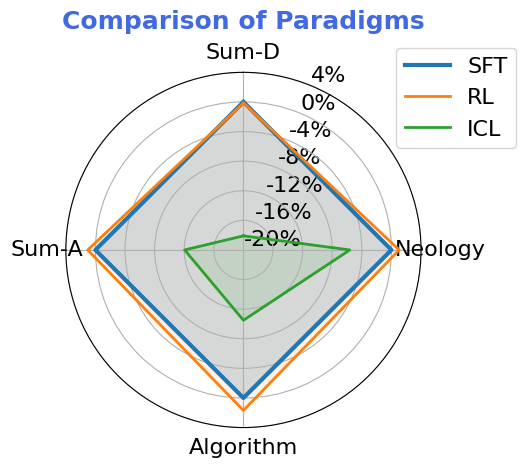

In [10]:
# Make the font size larger
plt.rcParams.update({'font.size': 16})

# Create a figure
fig, axs = plt.subplots(1, 1, figsize=(5, 5), subplot_kw=dict(polar=True))

plt.subplots_adjust(left=0.1,
                    bottom=0.1, 
                    right=1.8, 
                    top=0.9, 
                    wspace=0.8, 
                    hspace=0.9)

# Creating separate radar plots for each DataFrame entry
for i, (key, df) in enumerate(results_2.items()):
    # No adjustment needed for 'cp' entry, as it's already in the correct format
    create_radar_plots(df, key, axs)

# Show plot
plt.tight_layout()
plt.savefig("../image/radar_2.pdf", bbox_inches='tight')